Import 

In [1]:
import numpy as np
from collections import deque  
import cv2
import matplotlib.pyplot as plt
import glob


Camera clibration 

In [2]:
def cameraclibration():
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)
    
    cv2.destroyAllWindows()
    
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)        

    return mtx,dist

Combination of Color and Gradient Thresholding 

In [3]:
def color_gradient_thresh(img, s_thresh, l_thresh, sobel_kernel, mag_thresh,graddir_thresh):
              
    # Take both Sobel x and y gradients
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)            
    # threshold gradient magnitude
    gradmag_binary = np.zeros_like(gradmag)
    gradmag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])]
    
    # Take gradient orientation threshold 
    graddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    graddir_binary = np.zeros_like(graddir)
    graddir_binary[(graddir >= graddir_thresh[0]) & (graddir <= graddir_thresh[1])] = 1
    
    # Take both saturation and lightness channel for thresholding 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #threshold lightness
    l_binary = np.zeros_like(l_channel) 
    l_binary[(l_channel > l_thresh[0]) & (l_channel < l_thresh[1])] = 1  
    #threshold saturation 
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    binary = np.zeros_like(s_binary)
    binary[((l_binary == 1) | (s_binary == 1) | (gradmag_binary==1) | (graddir_thresh == 1))] = 1
        
    return binary

Perspective Transform 

In [4]:
def corners_unwarp(img, srcpoints, dstpoints):
                       
    img_size = (img.shape[1], img.shape[0])
    
    #calculate the transformation matrix 
    M = cv2.getPerspectiveTransform(srcpoints, dstpoints)
    warped = cv2.warpPerspective(img, M, img_size)

    return warped

Slide Window to find the initial fitted lines of lanes 

In [16]:
import numpy as np
import cv2

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    # It previously has nwindows lists of lists of pixels 
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img, histogram


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, histogram = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    # it uses all nonzero points inside the sliding window to fit a line  
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for checking
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return left_fit,right_fit,left_fitx,right_fitx,out_img,histogram

Search from Prior to find the fitted lines of lanes 

In [6]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
     ### This polynomial is for current frame 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    ### the polynomial parameters are from the previous frame, since we do not expect 
    ### a big change of the lanes from one frame to the next frame 
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    ## End visualization steps ##
    
            
    return left_fit, right_fit, left_fitx,right_fitx,result


Draw green area to mark the lane

In [7]:
def draw_lane_mark(binary_warped,left_fitx,right_fitx):    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    lane_marked_img = np.zeros_like(out_img)
    

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_line_pts = np.hstack((left_line, right_line))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(lane_marked_img, np.int_([lane_line_pts]), (0,255, 0))
    
    return lane_marked_img

Measure the lanes curvature close to vehicle  

In [8]:
def measure_curvature_real(left_fit, right_fit,y_eval):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension      
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

Define Line class to keep track of the processing steps

In [9]:
class Line():
    def __init__(self):
        # camera calibration
        self.calibration = False 
        self.camera_cali_matrix=None
        self.camera_dist=None
             
        #distance in meters of vehicle center from the line
        self.line_base_pos = None

    def camera_calibration_undistortion(self,img):
        #camera calibration
        if self.calibration==False:
            self.camera_cali_matrix,self.camera_dist = cameraclibration()
            self.calibration = True    
        #undistort image 
        undist = cv2.undistort(img, self.camera_cali_matrix, self.camera_dist, None, self.camera_cali_matrix)
        return undist                      

Perform camera calibration and image undistortion step 

Text(0.5,1,'Undistorted Image')

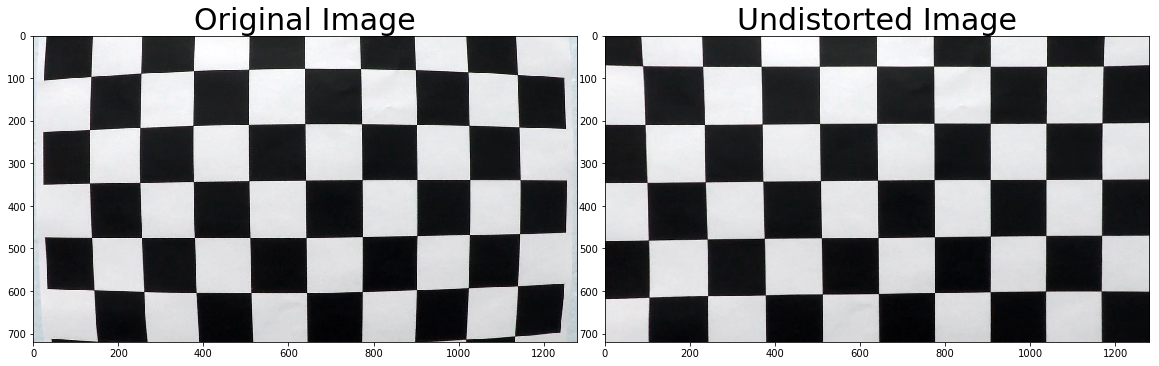

In [10]:
line=Line()
img = cv2.imread('camera_cal/calibration1.jpg')
undist = line.camera_calibration_undistortion(img)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5,1,'Undistorted Image')

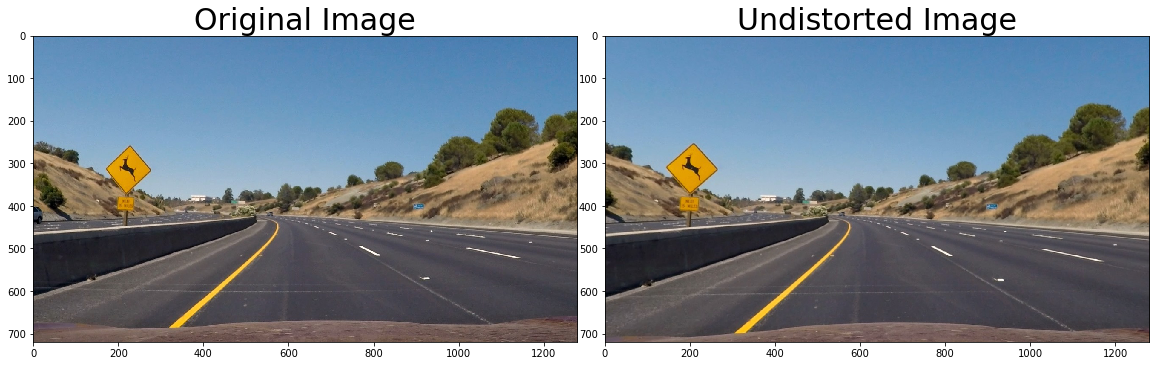

In [11]:
line=Line()
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undist = line.camera_calibration_undistortion(img)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

Perform color and gradient thresholding step 

Text(0.5,1,'Threshold Image')

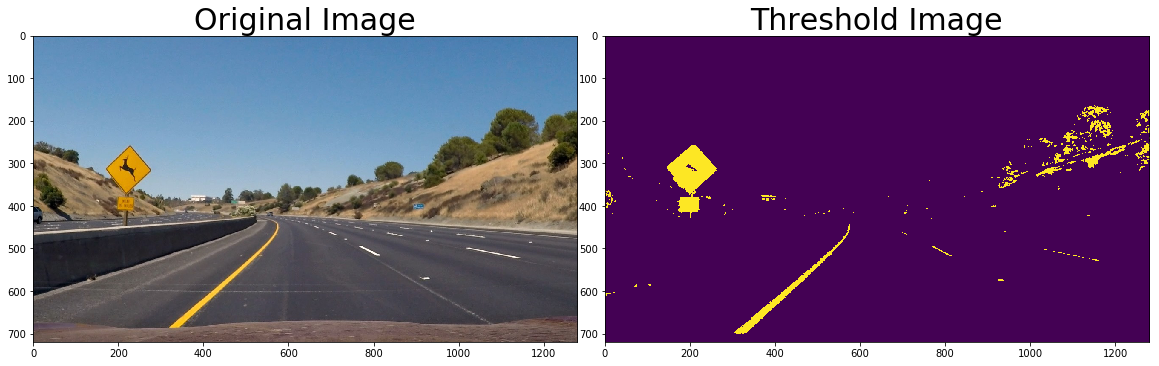

In [12]:
#color and gradient threshold 
binary_output = color_gradient_thresh(undist, s_thresh=(120,255), 
                            l_thresh=(220,255), sobel_kernel=3, mag_thresh=(25, 255),graddir_thresh=(0, np.pi/2))
# Visualize color_gradient thresholding
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(binary_output)
ax2.set_title('Threshold Image', fontsize=30)


Perform the perspective transform and transform the image to bird view image 

Text(0.5,1,'Perspective Transform Image')

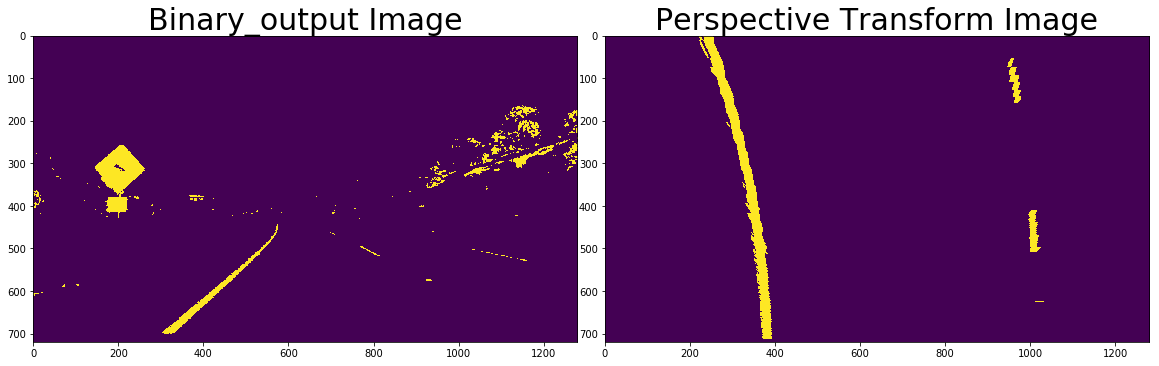

In [14]:
#perspective transform 
srcpoints = np.float32([[585,460],[203,720],[1127,720],[695,460]])
dstpoints = np.float32([[320,0],[320,720],[960,720],[960,0]])
binary_warped = corners_unwarp(binary_output, srcpoints, dstpoints)

# Visualize color_gradient thresholding
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(binary_output)
ax1.set_title('Binary_output Image', fontsize=30)
ax2.imshow(binary_warped)
ax2.set_title('Perspective Transform Image', fontsize=30)

Test the slidng window and search from prior steps 

Text(0.5,1,'Search from Prior Output Image')

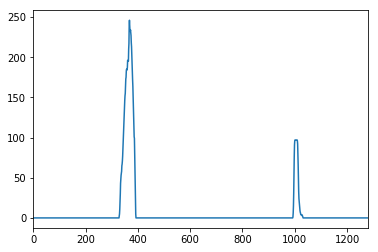

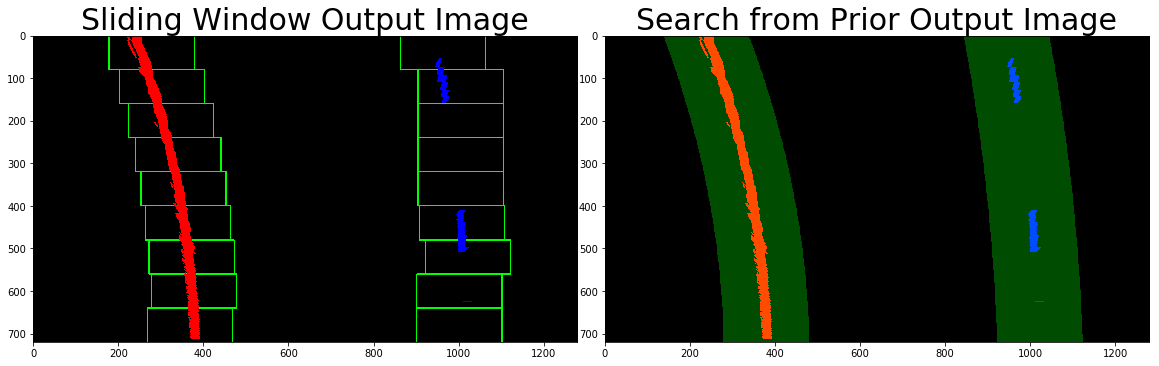

In [18]:
#sliding window and find the initial polynomial parameters 
left_fit,right_fit,left_fitx,right_fitx,sliding_out,histogram = fit_polynomial(binary_warped)
  
#search from prior
left_fit, right_fit, left_fitx, right_fitx,search_out = search_around_poly(binary_warped,left_fit,right_fit)


#print histogram from sliding window 
plt.plot(histogram)
plt.xlim(0, 1280)

#visualize sliding window and search from prior results 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(sliding_out)
ax1.set_title('Sliding Window Output Image', fontsize=30)
ax2.imshow(search_out)
ax2.set_title('Search from Prior Output Image', fontsize=30)

Highlight the lane with green 

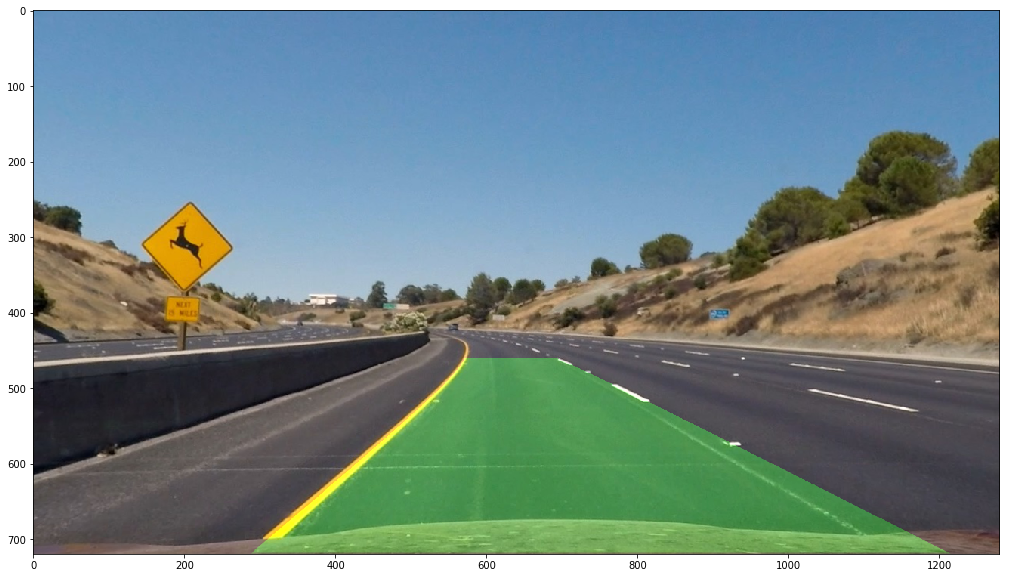

In [20]:
lane_marked_img = draw_lane_mark(binary_warped,left_fitx,right_fitx)
#perspective transform back to original perspective 
binary_original = corners_unwarp(lane_marked_img,dstpoints,srcpoints)
#combine original image with lane marked image 
result = cv2.addWeighted(undist, 1, binary_original, 0.3, 0)
plt.figure(figsize=(20,10))
plt.imshow(result)

Calculate the lane curvature and car central position relative to lane center 

In [22]:
#measure curvature 
y_eval=undist.shape[0]
left_radius, right_radius = measure_curvature_real(left_fit,right_fit,y_eval)
radius=(left_radius+right_radius)/2.0  
str1 = str('Radius of curvature' + '{:04.2f}'.format(radius/1000) + ' km')
print (str1)

#measure the car center relative to lane center 
xm_per_pix = 3.7/378 # meters per pixel in x dimension
line.line_base_pos=((left_fitx[-1] + right_fitx[-1])/2.0-undist.shape[1]/2.0)*xm_per_pix
if line.line_base_pos > 0:
    direction = 'left'
elif line.line_base_pos < 0:
    direction = 'right'
str2 = str('{:04.2f}'.format(line.line_base_pos) + ' m ' + direction + ' of center')
print (str2)

Radius of curvature3.70 km
0.59 m left of center
